In [ ]:
!pip install qc-procrustes

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 55 kB 2.9 MB/s 
     |████████████████████████████████| 297 kB 15.1 MB/s 
     |████████████████████████████████| 3.2 MB 50.8 MB/s 
     |████████████████████████████████| 121 kB 72.2 MB/s 
     |████████████████████████████████| 90 kB 8.8 MB/s 
     |████████████████████████████████| 84 kB 3.4 MB/s 
     |████████████████████████████████| 100 kB 9.0 MB/s 
  Created wheel for qc-procrustes: filename=qc_procrustes-1.0.0-py3-none-any.whl size=76078 sha256=6271cd8c4f3633df61a093f706b7f1e7c310f47b3e5368350a00993f51ee7f25
  Stored in directory: /root/.cache/pip/wheels/5c/5e/e7/e106da624dd09a030f6fcb95354936f6ba9b8a127d63e28599
Successfully built qc-procrustes
  Attempting uninstall: pluggy
    Found existing installation: pluggy 0.7.1
    Uninstalling pluggy-0.7.1:
      Successfully uninstalled pluggy-0.7.1
  Attempting uninstall: sphinx
    Found exist

In [ ]:
import jax
import jax.numpy as jnp
from jax import vmap

import numpy as np

from tqdm.notebook import tqdm

from scipy.stats import ortho_group
from procrustes import orthogonal
from procrustes.utils import compute_error, ProcrustesResult, setup_input_arrays

In [ ]:
"""from tutorial to get idea for error """

# random input 10x7 matrix A
a = np.random.rand(10, 7)

# random orthogonal 7x7 matrix T (acting as Q)
t = ortho_group.rvs(7)

# target matrix B (which is a shifted AT)
b = np.dot(a, t) + np.random.rand(1, 7)

# orthogonal Procrustes analysis with translation
result = orthogonal(a, b, scale=True, translate=True)

# compute transformed matrix A (i.e., A x Q)
aq = np.dot(result.new_a, result.t)

# display Procrustes results
print("Procrustes Error = ", result.error)
print("Procrustes l2 Error = ", np.linalg.norm(result.new_a@result.t - result.new_b, ord=2))
print("Procrustes l1 Error = ", np.linalg.norm(result.new_a@result.t - result.new_b, ord=1))

Procrustes Error =  5.229104805226128e-31
Procrustes l2 Error =  4.614963639070915e-16
Procrustes l1 Error =  1.2021633688519273e-15


In [508]:
"""TRENDAFILOV & WATSON, The \ell-1 oblique procrustes problem """

gamma = 0.1

def phi(t):
  """huber, eq 4 """
  return jax.lax.cond(
      jnp.abs(t)  <= gamma,
      lambda x : x**2 / 2,
      lambda x : gamma * (jnp.abs(x) - gamma / 2),
      t
  )

def d_phi(t):
  """huber deriv, eq 18 """
  return jax.lax.cond(
      jnp.abs(t)  <= gamma,
      lambda x : x,
      lambda x : gamma * jnp.sign(x),
      t
  )

def stationary_point(A, x, b_i):
  """stationary point, eq 15 """
  return (x.T@A.T@jnp.sign(A@x - b_i))*x - A.T@jnp.sign(A@x - b_i)

def project(x, g):
  """neg gradient projection, eq 13 & 14 """
  return (x.T@g)*x - g

def descent(A, x, b_i):
  """neg gradient step, eq 17 """
  return A.T@vmap(lambda a_i, b_ij : d_phi(a_i@x - b_ij), in_axes=(0,0))(A, b_i)

beta = 0.9
step_sizes = 1.0*jnp.power(beta,jnp.linspace(0,100,100)) # geometric progression of step sizes
def col_update(A, b, x, g):
  """update individual column of x """

  def line_search(step, x, g):
    """helper vmap over step sizes """
    return x + step * g

  # project descent direction
  g = project(x,g)
  # evaluate updates for different step sizes
  _xs = vmap(line_search, in_axes = (0, None, None))(step_sizes, x, g)
  _foc = jnp.linalg.norm(vmap(stationary_point, in_axes=(None, 0, None))(A, _xs, b), axis = 0)
  return _xs[_foc.argmin()] # choose best x wrt foc

def l1_procrustes(A, b):
  """PGD """
  A, b = setup_input_arrays(
      A,
      b,
      remove_zero_col=True,
      remove_zero_row=False,
      pad=False,
      translate=True,
      scale=True,
      check_finite=True,
      weight=None,
  )

  m, n = A.shape # m samples, dimension n
  x_0 = jnp.ones((n, n))  / jnp.sqrt(n) # intial columns of x on the unit n-sphere
  #x_0 = orthogonal(A, b).t # intial columns of x to solution to l2-proc problem
  x_i = x_0
  foc = []
  errors = []
  for _ in tqdm(range(200)):
    # solve n (dimension) independent sphere-constrained l1 problems in R-n with pgd
    # need to transpose since vmap out-axis is 0-axis (rows) by default
    g = vmap(descent, in_axes = (None, 1, 1))(A, x_i, b).T
    x_i = vmap(col_update, in_axes=(None, 1, 1, 1))(A, b, x_i, g).T
    # check foc and store errors
    f = jnp.linalg.norm(vmap(stationary_point,in_axes=(None, 1, 1))(A, x_i, b)).item()
    foc.append(f)
    error = compute_error(A, b, x_i)
    errors.append(error)

  return foc, errors, x_i

In [509]:
foc, errors, x_i = l1_procrustes(a, b)

  0%|          | 0/200 [00:00<?, ?it/s]

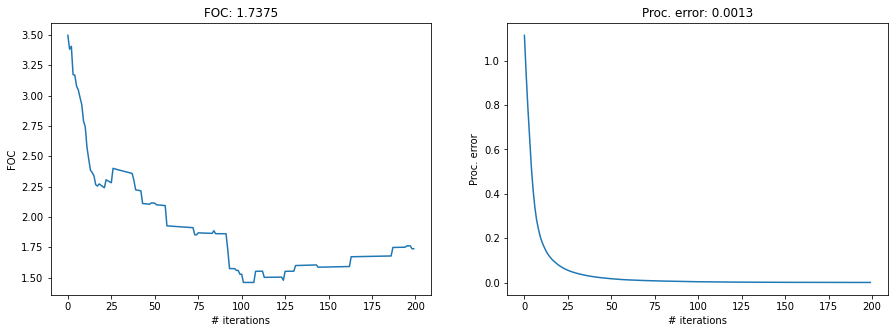

In [511]:
# want error ~1.2958384365546749e-15 to match l2 orthogonal proc.
# get error ~0.001 for gamma = 0.1-1.0 and unit init :( and foc not = 0 ??
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1,2, figsize=(15,5), sharex=True)
axes[0].plot(foc)
axes[1].plot(errors)
axes[0].set_ylabel('FOC')
axes[1].set_ylabel('Proc. error')

axes[0].set_title(f'FOC: {foc[-1]:.4f}')
axes[1].set_title(f'Proc. error: {errors[-1]:.4f}')
for ax in axes:
  ax.set_xlabel('# iterations')